## **Подготовка для работы в Google Colab или Kaggle**

# **Логистическая регрессия. Метрики качества**

In [15]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis)

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [16]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.11.x',
    'numpy': '1.26.4',
    'pandas': '2.1.4',
    'scikit-learn': '1.7.0',
    'statsmodels': '0.14.4',
    'matplotlib': '3.8.0',
    'seaborn': '0.13.2'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib == 'python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 11 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status}')

print('\nРезультат проверки: ', 
      '✓\nВсе версии соответствуют требованиям' 
      if environment_ok else 
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.11.x       | 3.11.8       | ✓
numpy           | 1.26.4       | 1.26.4       | ✓
pandas          | 2.1.4        | 2.1.4        | ✓
scikit-learn    | 1.7.0        | 1.7.0        | ✓
statsmodels     | 0.14.4       | 0.14.5       | x (требуется 0.14.4)
matplotlib      | 3.8.0        | 3.8.0        | ✓
seaborn         | 0.13.2       | 0.13.2       | ✓

Результат проверки:  x
ВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!
Для решения проблемы обратитесь к инструкции по настройке виртуального окружения


## **Импорт библиотек и вспомогательные функции**

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
#%pip install -U scipy statsmodels

In [19]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [20]:
RANDOM_STATE = 42

In [21]:
def ece_score(y_true, y_score, n_bins=10):
    """
    Возвращает значение метрики ECE для предсказанных вероятностей.
    Для расчета ECE используется метод равномерного (uniform) распределения бинов (интервалы бинов имеют равную длину).

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_score (numpy.ndarray): Предсказанные вероятности целевого класса.
        n_bins (int): Количество бинов. По умолчанию — 10.

    Возвращает:
        float: Значение метрики ECE для предсказанных вероятностей.
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_score, bins, right=True)
    ece = 0.0
    for i in range(1, n_bins + 1):
        bin_mask = (bin_indices == i)
        bin_size = bin_mask.sum()
        if bin_size > 0:
            bin_confidence = y_score[bin_mask].mean()
            bin_accuracy = y_true[bin_mask].mean()
            ece += (bin_size / len(y_true)) * abs(bin_accuracy - bin_confidence)
    return ece

## **Практическая часть**

### **Градиентный спуск**

Градиентный спуск (Gradient Descent) — это итерационный алгоритм численной оптимизации, используемый для нахождения локального минимума дифференцируемой функции. В контексте машинного обучения этой функцией является функция потерь (Loss Function), которая количественно оценивает ошибку модели.

Алгоритм градиентного спуска основан на свойстве градиента многомерной функции. Пусть $J$ — дифференцируемая функция, $\theta$ — вектор параметров функции. Тогда:

* Градиент $\nabla J(\theta)$, — это вектор, который указывает направление наискорейшего возрастания функции. 

* Антиградиент $-\nabla J(\theta)$ — это вектор, который указывает направление наискорейшего убывания функции.

**Алгоритм градиентного спуска (для функции потерь $J(\theta)$):**

1. Инициализация. Выбирается начальное приближение для вектора параметров $\theta_0$ (например, случайным образом).

2. Итерационное обновление. На каждом шаге алгоритма $t$ вектор параметров $\theta_t$ обновляется по следующему правилу:

$$\theta_{t+1} = \theta_{t} - \alpha \nabla J(\theta_t)$$

где $\theta_t$ — значение параметров на шаге $t$, $\alpha$ — параметр скорости обучения (learning rate), $\nabla J(\theta_t)$ — градиент функции потерь, вычисленный в точке $\theta_t$.

3. Критерий остановки. Итерационное обновление повторяется до тех пор, пока норма градиента не станет достаточно малой (что указывает на достижение точки, близкой к минимуму), либо пока не будет достигнуто заданное максимальное количество итераций.

Скорость обучения $\alpha$ является критически важным параметром:

* Если $\alpha$ слишком мала, алгоритм будет сходиться очень медленно. 

* Если $\alpha$ слишком велика, алгоритм может начать расходиться, постоянно увеличивая ошибку.

### ***Задание 1***

Пусть на отрезке $[-2; 2]$ задана функция $y(x)=x^4 + \sin(x)$ (функция с одним параметром).

Реализуйте простейший алгоритм градиентного спуска и найдите минимум функции `y_min`. Для нахождения минимума используйте параметры:

* Начальное приближение (`x0`): 1.

* Темп обучения (`learning_rate`): 0.1.

* Количество итераций (`n_iter`): 1000.

Рассчитайте оптимальный темп обучения — темп обучения, при котором алгоритм после первого же шага должен найти минимум функции `y_min`(начальное приближение `x0` — 1).

Проверьте четыре значения темпа обучения на сходимость реализованного алгоритма (начальное приближение `x0` — 1, количество итераций `n_iter` — 1000): 0.4, 0.5, 0.6, 0.7.

In [22]:
# Дополните функцию 

def func_y(x):
    """
    Возвращает значение функции y в точке x.

    Аргументы:
        x (int|float): Значение параметра функции y.

    Возвращает:
        float: Значение функции y в точке x.
    """
    return x ** 4 + np.sin(x)

In [23]:
# Дополните функцию gradient_y
# Подсказка: используйте производную функции y(x)

def gradient_y(x):
    """
    Возвращает значение градиента функции y в точке x.

    Аргументы:
        x (int|float): Значение параметра функции y.

    Возвращает:
        float: Значение градиента функции y в точке x.
    """
    return 4 * x ** 3 + np.cos(x)

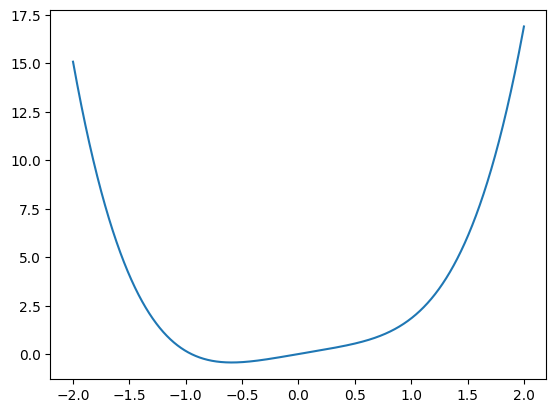

In [24]:
# Постройте график функции y на отрезке [-2; 2]
import math

x = np.linspace(-2, 2, num=10000)
y = func_y(x)

plt.plot(x, y)
plt.show()

In [25]:
# Задайте параметры для нахождения минимума

x0 = 1
learning_rate = 0.1
n_iter = 1000

In [26]:
# Для удобства рекомендуется реализовать градиентный спуск с помощью функции (не обязательно)
x = x0
for _ in range(n_iter):
    x = x - learning_rate * gradient_y(x)

In [27]:
# Найдите минимум функции y
x_min = x
y_min = func_y(x)

print(f"x_min ≈ {x_min:.6f},  y_min ≈ {y_min:.6f}")

x_min ≈ -0.591985,  y_min ≈ -0.435197


In [70]:
# Рассчитайте оптимальный темп обучения
# Начальное приближение (x0): 1
x0 = 1
g0 = gradient_y(x0)        # градиент в стартовой точке
lr_opt = x0 / g0           # из условия x1 = x0 - lr·g0 = 0

print(f"Оптимальный темп обучения: {lr_opt}")

Оптимальный темп обучения: 0.22024965137399424


In [29]:
# Проверьте четыре значения темпа обучения на сходимость реализованного алгоритма
# Начальное приближение (x0): 1
# Количество итераций (n_iter): 1000.

learning_rates = [0.4, 0.7, 0.6, 0.5]

print(" lr    x_min        y_min      шагов")
for lr in learning_rates:
    x = x0
    for step in range(n_iter):
        grad = gradient_y(x)
        if abs(grad) < 1e-8:          # ранний выход
            break
        x = x - lr * grad
    print(f"{lr}  {x:>10.6f}  {func_y(x):>10.2e}  {step+1}")

 lr    x_min        y_min      шагов
0.4   -0.591985   -4.35e-01  141
0.7         nan         nan  1000
0.6         nan         nan  1000
0.5         nan         nan  1000


# minimum = -0.4352

Оптимальный темп обучения: 0.22024965137399424  
Рассчитайте и выберите из списка значение оптимального темпа обучения.

Результат округлён до 4-х знаков после запятой.

0.1000  
ne 4.5431  
ne 0.1519  
не 0.2541  
# VERNO **0.3506**  
не 0.2537  
0.2833  
не 1.5916  

# Выберите все значения темпа обучения из списка, при которых реализованный алгоритм расходится.

0.4  
++ 0.5  
++ 0.6  
++ 0.7  

### **Датасет *Diabetes prediction dataset***

**Для решения заданий 2 — 9 рассмотрим датасет [Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data).**

**ВНИМАНИЕ:** При решении заданий **используйте файл diabetes.csv** из приложения к ноутбуку, поскольку исходный датасет был изменен авторами курса.

Набор данных предназначен для обучения и тестирования моделей бинарной классификации. Его основная цель — предсказать, есть ли у пациента диабет 2-го типа или нет. Набор данных включает в себя медицинские и демографические данные пациентов, а также информацию об их диабетическом статусе (положительный или отрицательный).

Целевая переменная — diabetes (диабетический статус):

* 1 — диагностирован диабет (**целевой класс**).

* 0 — диабет не диагностирован.

Датасет содержит признаки:

* gender — пол.

* age — возраст (в годах).

* hypertension — наличие гипертонии.

* heart_disease — наличие сердечно-сосудистых заболеваний.

* bmi — индекс массы тела (BMI).

* HbA1c_level — уровень гликированного гемоглобина.

* blood_glucose_level — уровень глюкозы в крови.

### **Калибровочная кривая и ECE**

**Калибровочная кривая (Calibration Curve)** — это инструмент для визуальной оценки того, насколько хорошо откалибрована модель. Она показывает соотношение между предсказанными вероятностями модели и фактической долей положительных исходов (реальным частотам положительных классов). На графике по оси X откладывается средняя предсказанная вероятность, а по оси Y — фактическая доля положительных классов.

**ECE (Expected Calibration Error)** — это метрика, которая позволяет численно измерить ошибку калибровки.

$$ECE=\sum_{m=1}^{M}{\frac{|B_m|}{n}{|acc(B_m) - conf(B_m)|}}$$

где $M$ — количество бинов, $|B_m|$ — число предсказаний в бине $B_m$, $n$ — общее количество наблюдений, $acc(B_m)$ — доля истинных положительных результатов (эмпирическая вероятность) в бине $B_m$, $conf(B_m)$ — средняя предсказанная вероятность в бине $B_m$.

При построении калибровочных кривых и расчёте ECE, все предсказания модели (например, из тестовой выборки) делятся на бины (группы) по уровню предсказанной вероятности. Как правило, используется метод равномерного (uniform) распределения бинов (интервалы бинов имеют равную длину). Например, в первый бин попадают все объекты с предсказанной вероятностью от 0 до 0.1, во второй — от 0.1 до 0.2, и так далее.

Подробнее можно изучить по **ссылкам:**

* [Калибровочные кривые | scikit-learn.ru](https://scikit-learn.ru/stable/modules/calibration.html#calibration-curve)

* [Expected Calibration Error (ECE): A Step-by-Step Visual Explanation | towardsdatascience.com](https://towardsdatascience.com/expected-calibration-error-ece-a-step-by-step-visual-explanation-with-python-code-c3e9aa12937d/)


### **Когда использовать AUC, а когда — ECE**

**AUC (Area Under the ROC Curve)** — это метрика качества ранжирования. Она показывает, насколько хорошо модель способна отличать один класс от другого, присваивая объектам положительного класса более высокие оценки, чем объектам отрицательного. Высокий AUC означает, что модель хорошо разделяет классы.

**Использовать AUC следует, когда в решаемой задаче важен порядок объектов, а не точные значения вероятностей.** 

**ECE (Expected Calibration Error)** — это метрика качества вероятностей. Она оценивает, соответствуют ли предсказанные моделью вероятности реальным частотам событий. Низкий ECE означает, что модель надежна, и её вероятностям можно доверять.

**Использовать ECE следует, когда в решаемой задаче важны точные вероятности, а цена ошибки высока.**

### ***Задание 2***

Выполните предобработку датасета (см. код задания) и обучите три модели логистической регрессии (LogisticRegression) на обучающей выборке:

* `lr_diab` — логистическая регрессия **без регуляризации** на данных **без масштабирования** (`X_diab_train`).

* `lr_diab_def` — логистическая регрессия **с регуляризацией по умолчанию** на данных **с масштабированием** (`X_diab_train_scaled`).

* `lr_diab_opt` — логистическая регрессия **с оптимальным гиперпараметром регуляризации** на данных **с масштабированием** (`X_diab_train_scaled`). Оптимальный гиперпараметр регуляризации подберите с помощью GridSearchCV.

Сравните качество калибровки моделей **на тестовой выборке**. Для этого постройте калибровочные кривые (функция [calibration_curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html)) и посчитайте метрику ECE (функция ece_score) для каждой из обученных моделей. На основе значения ECE выберите модель с наилучшей калибровкой. 

Сравните значение метрики AUC **на тестовой выборке** для обученных моделей. 

In [30]:
# Считайте набор данных

df_diab = pd.read_csv('diabetes.csv')
df_diab

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,57.0,No,No,18.87,4.8,140,0
1,Female,39.0,No,No,27.32,6.1,130,0
2,Female,15.0,No,No,38.72,5.7,159,0
3,Female,60.0,No,No,25.10,5.7,140,0
4,Male,12.0,No,No,17.26,4.5,126,0
...,...,...,...,...,...,...,...,...
99977,Female,38.0,No,No,32.84,4.0,155,0
99978,Male,17.0,No,No,25.26,5.0,155,0
99979,Male,2.0,No,No,27.32,5.0,90,0
99980,Female,80.0,No,No,20.54,6.6,140,0


In [31]:
# Используя метод info, определите типы признаков

df_diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99982 entries, 0 to 99981
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99982 non-null  object 
 1   age                  99982 non-null  float64
 2   hypertension         99982 non-null  object 
 3   heart_disease        99982 non-null  object 
 4   bmi                  99982 non-null  float64
 5   HbA1c_level          99982 non-null  float64
 6   blood_glucose_level  99982 non-null  int64  
 7   diabetes             99982 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 6.1+ MB


In [32]:
# Создайте списки количественных и категориальных переменных (не включая целевую переменную)
target = 'diabetes'

diab_num_feat = df_diab.select_dtypes(include=['int64', 'float64']).columns.drop(target).tolist()
diab_cat_feat = df_diab.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

In [33]:
# --- объясняемые факторы ---
X_diab = df_diab.drop(columns='diabetes')

# --- целевая переменная ---
y_diab = df_diab['diabetes']

In [34]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder

diab_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

# --- кодируем категориальные признаки ---
X_diab_encoded = diab_encoder.fit_transform(X_diab[diab_cat_feat])

# --- добавляем новые столбцы и удаляем старые категориальные ---
X_diab = X_diab.join(X_diab_encoded)
X_diab = X_diab.drop(columns=diab_cat_feat)

In [35]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_diab_train, X_diab_test, y_diab_train, y_diab_test = train_test_split(
    X_diab, y_diab,
    test_size=0.4,
    stratify=y_diab,
    random_state=RANDOM_STATE
)

In [36]:
# Масштабируйте количественные признаки
#   train -> fit_transform
#   test -> transform

diab_scaler = StandardScaler().set_output(transform='pandas')

num_cols = diab_num_feat  # список числовых столбцов, создан ранее

X_diab_train_scaled = X_diab_train.copy()
X_diab_test_scaled  = X_diab_test.copy()

# fit на train, transform на обе выборки
X_diab_train_scaled[num_cols] = diab_scaler.fit_transform(X_diab_train[num_cols])
X_diab_test_scaled[num_cols]  = diab_scaler.transform(X_diab_test[num_cols])

In [37]:
# Обучите модель lr_diab без регуляризации на данных без масштабирования
# Не забудьте зафиксировать RANDOM_STATE

lr_diab = LogisticRegression(penalty=None, random_state=RANDOM_STATE).fit(X_diab_train, y_diab_train)

In [38]:
# Обучите модель lr_diab_def с регуляризацией по умолчанию на данных с масштабированием
# Не забудьте зафиксировать RANDOM_STATE

lr_diab_def = LogisticRegression(random_state=RANDOM_STATE).fit(X_diab_train_scaled, y_diab_train)

In [110]:
# Обучите модель lr_diab_opt с оптимальным гиперпараметром регуляризации на данных с масштабированием
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'C' : [0.1, 0.3, 0.5, 0.7, 1.0]}
cv = 5

cv_lr_diab_opt = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE),
    param_grid=params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
cv_lr_diab_opt.fit(X_diab_train_scaled, y_diab_train)
lr_diab_opt = cv_lr_diab_opt.best_estimator_

In [111]:
# Выведите оптимальное значение гиперпараметра C

C_opt = cv_lr_diab_opt.best_params_['C']
print(C_opt)

0.1


In [41]:
# Выполните предсказание вероятностей целевого класса на тестовой выборке моделью lr_diab
# Учтите, что lr_diab обучалась на данных без масштабирования

y_test_proba_lr_diab = lr_diab.predict_proba(X_diab_test)[:, 1]

In [42]:
# Выполните предсказание вероятностей целевого класса на тестовой выборке моделью lr_diab_def
# Учтите, что lr_diab_def обучалась на данных с масштабированием

y_test_proba_lr_diab_def = lr_diab_def.predict_proba(X_diab_test_scaled)[:, 1]

In [43]:
# Выполните предсказание вероятностей целевого класса на тестовой выборке моделью lr_diab_opt
# Учтите, что lr_diab_opt обучалась на данных с масштабированием

y_test_proba_lr_diab_opt = lr_diab_opt.predict_proba(X_diab_test_scaled)[:, 1]

In [44]:
# Просчитайте калибровочные кривые моделей на тестовой выборке, используя calibration_curve (n_bins=10)

prob_true_lr_diab, prob_pred_lr_diab = calibration_curve(y_diab_test, y_test_proba_lr_diab, n_bins=10)
prob_true_lr_diab_def, prob_pred_lr_diab_def = calibration_curve(y_diab_test, y_test_proba_lr_diab_def, n_bins=10)
prob_true_lr_diab_opt, prob_pred_lr_diab_opt = calibration_curve(y_diab_test, y_test_proba_lr_diab_opt, n_bins=10)

In [100]:
prob_true_lr_diab, prob_pred_lr_diab, prob_true_lr_diab_def, prob_pred_lr_diab_def, prob_true_lr_diab_opt, prob_pred_lr_diab_opt

(array([0.01497087, 0.12982625, 0.18970737, 0.28919861, 0.39050132,
        0.52866242, 0.59731544, 0.76744186, 0.88418079, 0.98835404]),
 array([0.01394134, 0.14169905, 0.24527386, 0.34566689, 0.44760647,
        0.54873319, 0.65054452, 0.75410422, 0.85355212, 0.97204509]),
 array([0.01439172, 0.13045519, 0.19609856, 0.2689769 , 0.39071038,
        0.48160535, 0.61428571, 0.74089069, 0.93452381, 0.99924925]),
 array([0.01255126, 0.1415057 , 0.2456315 , 0.34651006, 0.44546948,
        0.54747187, 0.64705147, 0.74691614, 0.85203177, 0.97527623]),
 array([0.0142579 , 0.1310792 , 0.19477912, 0.27704918, 0.38624339,
        0.4965035 , 0.62190813, 0.75502008, 0.93993994, 0.99923896]),
 array([0.01282003, 0.14131327, 0.24528339, 0.34621286, 0.4472804 ,
        0.54885964, 0.6459758 , 0.74779593, 0.85190376, 0.97438082]))

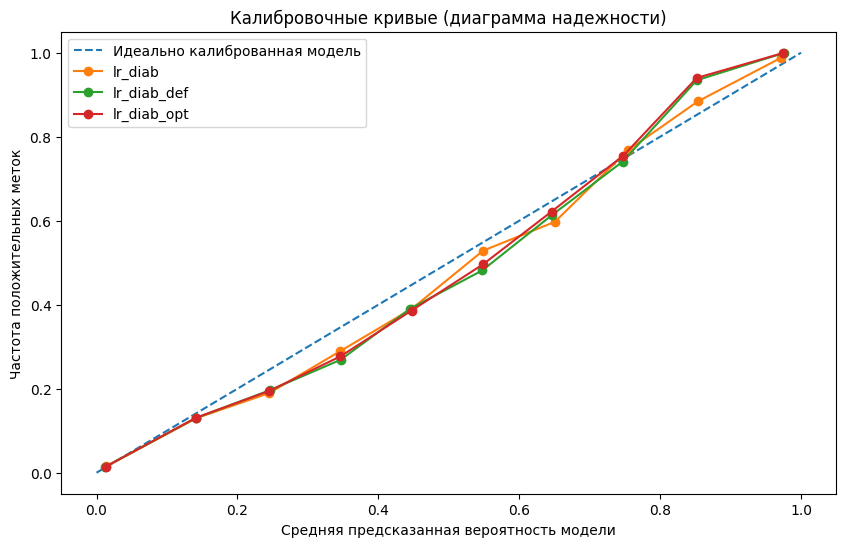

In [45]:
# Визуализируйте калибровочные кривые

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Идеально калиброванная модель')
plt.plot(prob_pred_lr_diab, prob_true_lr_diab, marker='o', label='lr_diab')
plt.plot(prob_pred_lr_diab_def, prob_true_lr_diab_def, marker='o', label='lr_diab_def')
plt.plot(prob_pred_lr_diab_opt, prob_true_lr_diab_opt, marker='o', label='lr_diab_opt')
plt.xlabel('Средняя предсказанная вероятность модели')
plt.ylabel('Частота положительных меток')
plt.title('Калибровочные кривые (диаграмма надежности)')
plt.legend()
plt.show()

In [46]:
# Посчитайте метрику ECE для каждой из моделей, используя функцию ece_score
ece_lr_diab     = ece_score(y_diab_test, y_test_proba_lr_diab,     n_bins=10)
ece_lr_diab_def = ece_score(y_diab_test, y_test_proba_lr_diab_def, n_bins=10)
ece_lr_diab_opt = ece_score(y_diab_test, y_test_proba_lr_diab_opt, n_bins=10)
print(ece_lr_diab,ece_lr_diab_def,ece_lr_diab_opt)

0.0056417305142360845 0.007259734825699403 0.006781838455480556


In [47]:
# Посчитайте метрику AUC для каждой из моделей, используя функцию roc_auc_score
auc_lr_diab     = roc_auc_score(y_diab_test, y_test_proba_lr_diab)
auc_lr_diab_def = roc_auc_score(y_diab_test, y_test_proba_lr_diab_def)
auc_lr_diab_opt = roc_auc_score(y_diab_test, y_test_proba_lr_diab_opt)
print(auc_lr_diab,auc_lr_diab_def,auc_lr_diab_opt)

0.959474774989109 0.961813931787018 0.9618520377571409


# Задание 2 оно же 4/18
**МВЕРНО!**

Для любой задачи бинарной классификации (например, определение наличия или отсутствия болезни) калибровка важнее, чем AUC.  
++++ Калибровка модели очень важна, когда нужны точные вероятности (например, оценка риска в медицине или кредитовании).  
Метрика AUC, как и ECE, учитывает, насколько точны предсказанные вероятности.  
++++ Когда важны точные вероятности, при выборе модели нужно сравнивать ECE, а не AUC.  
++++ Перед обучением модели логистической регрессии с регуляризацией необходимо предварительно выполнить масштабирование данных.  
Значение оптимального параметра регуляризации логистической регрессии не зависит от того, стандартизированы данные или нет.  

✓ Калибровка модели очень важна, когда нужны точные вероятности (например, оценка риска в медицине или кредитовании).  
✓ Когда важны точные вероятности, при выборе модели нужно сравнивать ECE, а не AUC.  
✓ Перед обучением модели логистической регрессии с регуляризацией необходимо предварительно выполнить масштабирование данных.  

Определите оптимальный гиперпараметр регуляризации для модели lr_diab_opt (C_opt) с помощью GridSearchCV.

Выберите оптимальное значение гиперпараметра C (C_opt) из списка.

**0.1**  
**0.3**  
**0.5**  
VERNO! 0.7  
1.0  


✓ ??? Графики калибровочных кривых позволяют сделать вывод о том, что все модели склонны всегда переоценивать вероятности (для данного RANDOM_STATE).  
✓ Если калибровочная кривая модели проходит ниже диагонали (ниже графика идеальной калибровки), это означает, что модель переоценивает вероятности положительного класса. (общий факт, не зависящий от чисел)  
✓ Модель без регуляризации (lr_diab) показывает лучшую калибровку, но при этом ее кривая не является идеальной.
(именно она имеет наименьший ECE)

# VERNO 6/18
Графики калибровочных кривых позволяют сделать вывод о том, что все модели склонны всегда переоценивать вероятности (для данного RANDOM_STATE).  
++++ Если калибровочная кривая модели проходит ниже диагонали (ниже графика идеальной калибровки), это означает, что модель переоценивает вероятности положительного класса.  
Для данного RANDOM_STATE все три модели систематически занижают предсказанные вероятности (см. график калибровочных кривых).  
++++ Модель без регуляризации (lr_diab) показывает лучшую калибровку, но при этом ее кривая не является идеальной.  
Для данного RANDOM_STATE наилучшей моделью с точки зрения ECE является модель с оптимальным параметром регуляризации (lr_diab_opt).  
Для данного RANDOM_STATE наилучшей моделью с точки зрения AUC является модель без регуляризации (lr_diab).  

### ***Задание 3***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Датасет **до масштабирования** из задания 2: `X_diab`, `y_diab`.

* Оптимальное значение гиперпараметра регуляризации C из задания 2: `C_opt`. 

Проверьте, является ли разница в калибровочной точности моделей `lr_diab`, `lr_diab_def`, `lr_diab_opt` значимой (равны ли метрики ECE для данных моделей в среднем). Для проверки равенства средних значений в трех группах (векторы значений ECE для каждой из трех моделей) используйте t-тесты и F-тест для регрессии statsmodels (OLS) с фиктивными переменными для групп.

**Посчитайте векторы значений ECE для 100 различных random_state.** Для каждой итерации $i=0,...,99$ (100 итераций):

**ВНИМАНИЕ:** Где возможно, фиксируйте random_state для итерации $i$ на значении $i$.

1. Разделите обучающую выборку `X_diab` на обучающую (60%, `X_diab_sample_train`) и валидационную (40%, `X_diab_sample_val`) **подвыборки** со стратификацией по целевой переменной. Не забудьте зафиксировать random_state=$i$.

2. Обучите три модели логистической регрессии на обучающей подвыборке `X_diab_sample_train` (не забудьте масштабировать подвыборки `X_diab_sample_train` и `X_diab_sample_val` для моделей с регуляризацией, зафиксировать random_state=$i$):
    
    * `lr_diab_sample` — логистическая регрессия **без регуляризации** на данных **без масштабирования** (`X_diab_sample_train`).

    * `lr_diab_sample_def` — логистическая регрессия **с регуляризацией по умолчанию** на данных **с масштабированием** (`X_diab_sample_train_scaled`).

    * `lr_diab_sample_opt` — логистическая регрессия **с оптимальным гиперпараметром регуляризации** `C_opt` на данных **с масштабированием** (`X_diab_sample_train_scaled`). Используйте оптимальный гиперпараметр регуляризации `C_opt` из задания 2.

3. Посчитайте метрику ECE (функция ece_score) для каждой из обученных моделей.

Используя линейную регрессию statsmodels (OLS) и векторы значений ECE, **проверьте гипотезу о равенстве средних значений метрики ECE** в трех группах:

1. Обучите модель линейной регрессии statsmodels (OLS) `ols_ece_diab` с факторными группами (с фиктивными переменными):

    $$y = \alpha+\beta_{default}D_{default}+\beta_{optimal}D_{optimal}​+ϵ$$

    где $\alpha=\text{ECE}^{no\_penalty}_{mean}$ — среднее значение ECE в группе с меткой $M^{no\_penalty}$ (среднее ECE для модели `lr_diab`), $D_{m}$ — индикатор модели с меткой $M^{m}$.



2. Интерпретируя summary модели `ols_ece_diab`, проверьте гипотезу о равенстве средних в трех группах с помощью t-теста для коэффициентов $\beta_{default}$ и $\beta_{optimal}$, а также F-теста для всей модели.

In [48]:
# Посчитайте векторы значений ECE для 100 различных random_state
# Для записи результатов итераций создадим датафрейм diab_ece_scores, заполненный нулями

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# заранее подготовлен scalers и C_opt
C_opt = cv_lr_diab_opt.best_params_['C']   # из задания 2

diab_ece_scores = pd.DataFrame({
    'ece_no_penalty': np.zeros(100),
    'ece_default': np.zeros(100),
    'ece_optimal': np.zeros(100)
}, index=range(100))

for i in range(100):
    # 1. разбиение 60/40 со стратификацией
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_diab, y_diab, test_size=0.4, random_state=i, stratify=y_diab)
    
    # 2. масштабирование ТОЛЬКО числовых колонок
    scaler = StandardScaler()
    num_cols = diab_num_feat
    X_tr_scaled = X_tr.copy()
    X_val_scaled = X_val.copy()
    X_tr_scaled[num_cols] = scaler.fit_transform(X_tr[num_cols])
    X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
    
    # 3. обучение моделей
    lr_no = LogisticRegression(penalty=None, solver='lbfgs', random_state=i).fit(X_tr, y_tr)
    lr_def = LogisticRegression(random_state=i).fit(X_tr_scaled, y_tr)
    lr_opt = LogisticRegression(C=C_opt, random_state=i).fit(X_tr_scaled, y_tr)
    
    # 4. вероятности на валидации
    p_no  = lr_no.predict_proba(X_val)[:, 1]
    p_def = lr_def.predict_proba(X_val_scaled)[:, 1]
    p_opt = lr_opt.predict_proba(X_val_scaled)[:, 1]
    
    # 5. ECE
    diab_ece_scores.iloc[i] = [
        ece_score(y_val, p_no),
        ece_score(y_val, p_def),
        ece_score(y_val, p_opt)
    ]

In [101]:
# Выведите средние значения ECE в каждой из трех групп

print(diab_ece_scores.mean())

ece_no_penalty    0.006288
ece_default       0.006778
ece_optimal       0.006432
dtype: float64


# Рассчитайте и выберите из списка среднее значение метрики ECE для модели без регуляризации (колонка ece_no_penalty) по результатам 100 итераций.

# VERNO

0.0068  
**0.0062**  
0.0055  
0.0061  
0.0624  
0.0053  
0.0067  
0.0072  

In [50]:
# Представим значения ECE в виде двух векторов: метка группы (group) и ECE наблюдения, соответствующего метке (ECE)

diab_ece_groups = diab_ece_scores.melt()
diab_ece_groups.columns = ['group', 'ECE']
diab_ece_groups

,group,ECE
0,ece_no_penalty,0.004973
1,ece_no_penalty,0.005169
2,ece_no_penalty,0.006416
3,ece_no_penalty,0.009614
4,ece_no_penalty,0.005054
...,...,...
295,ece_optimal,0.006911
296,ece_optimal,0.006206
297,ece_optimal,0.007364
298,ece_optimal,0.007176


In [51]:
# Сформируйте датафрейм для проверки гипотезы
# Добавьте в датафрейм два столбца с фиктивными переменными:
#   D_default = 1, если group = 'ece_default'; 0 — иначе
#   D_optimal = 1, если group = 'ece_optimal'; 0 — иначе

diab_ece_groups['D_default'] = (diab_ece_groups['group'] == 'ece_default').astype(int)
diab_ece_groups['D_optimal'] = (diab_ece_groups['group'] == 'ece_optimal').astype(int)
diab_ece_groups = diab_ece_groups.drop(columns=['group'])
diab_ece_groups 

,ECE,D_default,D_optimal
0,0.004973,0,0
1,0.005169,0,0
2,0.006416,0,0
3,0.009614,0,0
4,0.005054,0,0
...,...,...,...
295,0.006911,0,1
296,0.006206,0,1
297,0.007364,0,1
298,0.007176,0,1


In [52]:
# Выделите столбец ECE датафрейма diab_ece_groups в отдельную переменную

y_diab_ece_groups = diab_ece_groups['ECE']
X_diab_ece_groups = diab_ece_groups.drop(columns=['ECE'])

In [53]:
# Проверьте гипотезу о равенстве средних значений метрики ECE в трех группах, используя ols_ece_diab
# Выведите summary для ols_ece_diab
# Перед обучением ols_ece_diab необходимо добавить константу к X_diab_ece_groups с помощью метода add_constant

X_diab_ece_groups_const = sm.add_constant(X_diab_ece_groups)
ols_ece_diab = OLS(y_diab_ece_groups, X_diab_ece_groups_const).fit()
print(ols_ece_diab.summary())

                            OLS Regression Results                            
Dep. Variable:                    ECE   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     6.298
Date:                Wed, 08 Oct 2025   Prob (F-statistic):            0.00209
Time:                        18:01:11   Log-Likelihood:                 1646.8
No. Observations:                 300   AIC:                            -3288.
Df Residuals:                     297   BIC:                            -3276.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.000     62.593      0.0

# Проанализируйте summary модели ols_ece_diab. Какие выводы можно сделать о статистической значимости различий средних значений ECE между группами?

 

- По результатам F-теста можно утверждать, что c 5% значимостью различия между группами статистически не значимы.  
+++++ Коэффициенты при D_default и D_optimal не значимы, так как их значения близки к нулю.  
- Коэффициент при D_optimal статистически значим (p-value < 0.05), что говорит о значимом различии ECE между моделью без регуляризации (no_penalty) и моделью с оптимальным параметром регуляризации (optimal).  
++++ По результатам t-теста с 5% значимостью отклоняем гипотезу о том, что среднее значение ECE равно для модели без регуляризации (no_penalty) и модели с регуляризацией по умолчанию (default).

  **2,3 тоде не верно**

# VERNO  8/18
По результатам F-теста можно утверждать, что c 5% значимостью различия между группами статистически не значимы.  
Коэффициенты при D_default и D_optimal не значимы, так как их значения близки к нулю.  
++++ Коэффициент при D_optimal статистически значим (p-value < 0.05), что говорит о значимом различии ECE между моделью без регуляризации (no_penalty) и моделью с оптимальным параметром регуляризации (optimal).  
++++ По результатам t-теста с 5% значимостью отклоняем гипотезу о том, что среднее значение ECE равно для модели без регуляризации (no_penalty) и модели с регуляризацией по умолчанию (default).


### ***Задание 4***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Тестовую выборку **до масштабирования** из задания 2: `X_diab_test`, `y_diab_test`.

* Обученную модель `lr_diab` из задания 3.

В рамках тестовой выборки `X_diab_test` отберите несколько пациентов по заданным условиям (метод [query](https://pandas.pydata.org/docs/user_guide/indexing.html#the-query-method)) и с помощью модели `lr_diab` предскажите вероятности целевого класса для каждого из этих пациентов. Условия для отбора пациентов:

* Возраст — 54.

* Пол — мужчина.

* Наличие гипертонии — нет.

* Наличие сердечно-сосудистых заболеваний — да.

* Индекс массы тела (BMI) — от 27 (включительно) до 28 (включительно).

* Уровень гликированного гемоглобина — не меньше 6.

* Уровень глюкозы в крови — не больше 155.

In [112]:
X_diab_test.describe()

,age,bmi,HbA1c_level,blood_glucose_level,gender_Male,hypertension_Yes,heart_disease_Yes
count,39993.000000,39993.000000,39993.000000,39993.000000,39993.000000,39993.000000,39993.000000
mean,41.960531,27.323465,5.527937,138.135924,0.415073,0.075013,0.040357
std,22.511321,6.607343,1.069534,40.809709,0.492741,0.263416,0.196798
min,0.080000,10.140000,3.500000,80.000000,0.000000,0.000000,0.000000
25%,24.000000,23.620000,4.800000,100.000000,0.000000,0.000000,0.000000
50%,43.000000,27.320000,5.800000,140.000000,0.000000,0.000000,0.000000
75%,60.000000,29.610000,6.200000,159.000000,1.000000,0.000000,0.000000
max,80.000000,95.220000,9.000000,300.000000,1.000000,1.000000,1.000000


In [ ]:
# В рамках тестовой выборки X_diab_test отберите несколько пациентов по заданным условиям

X_diab_test_sample = X_diab_test.query(
    "age == 54 and "
    "gender_Male == 1 and "          # 1 = мужчина (если 0/1 кодировка)
    "hypertension_Yes == 0 and "
    "heart_disease_Yes == 1 and "
    "bmi >= 27 and bmi <= 28 and "
    "HbA1c_level >= 6 and "
    "blood_glucose_level <= 155"
)
diab_test_sample_ids = X_diab_test_sample.index
X_diab_test_sample

In [ ]:
# C помощью модели lr_diab предскажите вероятности целевого класса для каждого из пациентов в X_diab_test_sample

y_test_sample_lr_diab = pd.Series(lr_diab.predict_proba(X_diab_test_sample)[:, 1], index=diab_test_sample_ids)
y_test_sample_lr_diab

# задание 9/18

Сколько пациентов было отобрано в тестовой выборке X_diab_test по заданным в задании условиям? Выберите из списка количество отобранных пациентов  

 **3**  
 

# Выберите все верные утверждения из списка.

# **Verno**

Все отобранные пациенты в действительности имеют отрицательный диабетический статус (не имеют диабета).  
++++ При стандартном пороге классификации (50%) модель lr_diab предсказала бы наличие диабета только у одного из отобранных пациентов.  
++++ ?? Если порог классификации установлен на значении 50%, то модель правильно предскажет диабетический статус всех отобранных пациентов.  
Пациент с индексом 3327 имеет самый низкий уровень параметра blood_glucose_level среди отобранных пациентов.  
Исходя из прогноза модели, все пациенты имеют примерно одинаковую вероятность наличия диабета, так как у них совпадают возраст, пол и другие признаки.  

### ***Задание 5***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Тестовую выборку **до масштабирования** из задания 2: `X_diab_test`, `y_diab_test`.

* Датасет с отобранными в задании 4 пациентами: `X_diab_test_sample`.

* Обученную модель `lr_diab` из задания 3.

Для отобранных пациентов (`X_diab_test_sample`) скорректируйте данные при следующих **последовательных** событиях:

1. Событие 1: коррекция оборудования. Выяснилось, что оборудование, собирающее анализы у пациентов, завышает значение уровня гликированного гемоглобина (HbA1c_level) у всех отобранных пациентов на 0.2. Уменьшите значение гликированного гемоглобина (HbA1c_level) у отобранных пациентов на 0.2.

2. Событие 2: уточнение диагноза. Благодаря новым методам диагностики, у некоторых пациентов была диагностирована гипертония, в том числе и у всех отобранных пациентов. Для отобранных пациентов установите флаг наличия гипертонии (hypertension = 1).

3. Событие 3: учет погрешности измерений. Чтобы учесть возможность ошибки в результатах анализов, было принято решение также считать вероятность диабета в случае, когда уровень глюкозы в крови (blood_glucose_level) выше текущего на величину стандартного отклонения в выборке (тестовой). Для отобранных пациентов увеличьте уровень глюкозы в крови (blood_glucose_level) на величину стандартного отклонения blood_glucose_level в тестовой выборке `X_diab_test_sample`.

После каждой коррекции данных определите изменение вероятности предсказания наличия диабета для отобранных пациентов.

In [57]:
# Событие 1: коррекция оборудования
# Определите изменение вероятности предсказания наличия диабета при изменении HbA1c_level
# сохраняем исходные вероятности до любых коррекций
proba_before = lr_diab.predict_proba(X_diab_test_sample)[:, 1].copy()

# делаем копию данных для коррекции
X_ev1 = X_diab_test_sample.copy()
X_ev1['HbA1c_level'] -= 0.2          # уменьшаем на 0.2

# новые вероятности
proba_ev1 = lr_diab.predict_proba(X_ev1)[:, 1]

# изменение
delta_ev1 = proba_ev1 - proba_before
delta_ev1

array([-0.00915913, -0.01063424, -0.10426574])

In [58]:
# Событие 2: уточнение диагноза
# Определите изменение вероятности предсказания наличия диабета при изменении hypertension
# ВНИМАНИЕ: корректировка hypertension происходит после изменения HbA1c_level
# продолжаем цепочку: берём данные после события 1
X_ev2 = X_ev1.copy()
X_ev2['hypertension_Yes'] = 1          # устанавливаем флаг 1

proba_ev2 = lr_diab.predict_proba(X_ev2)[:, 1]
delta_ev2 = proba_ev2 - proba_ev1      # изменение относительно события 1
delta_ev2

array([0.00457575, 0.00424085, 0.04589615])

In [59]:
# Событие 3: учет погрешности измерений
# Определите изменение вероятности предсказания наличия диабета при изменении blood_glucose_level
# ВНИМАНИЕ: корректировка blood_glucose_level происходит после изменения HbA1c_level и hypertension
std_glucose = X_diab_test['blood_glucose_level'].std()

X_ev3 = X_ev2.copy()
X_ev3['blood_glucose_level'] += std_glucose          # + стандартное отклонение

proba_ev3 = lr_diab.predict_proba(X_ev3)[:, 1]
delta_ev3 = proba_ev3 - proba_ev2                   # изменение относительно события 2
delta_ev3

array([0.01612891, 0.06192037, 0.31117628])

# Задание 5  !!! Verno!
Выберите все верные утверждения из списка.

+++++ При стандартном пороге классификации (50%) по итогам всех событий (после изменения blood_glucose_level) модель lr_diab изменила бы свой диагноз хотя бы у одного из пациентов (относительно исходных вероятностей).  
При изменении параметра hypertension (hypertension_Yes) наибольшее по абсолютной величине изменение в вероятности среди отобранных пациентов наблюдается у пациента с индексом 3327.  
При изменении параметра HbA1c_level наибольшее по абсолютной величине изменение в вероятности среди отобранных пациентов наблюдается у пациента с индексом 3327.  
Наибольшее по абсолютной величине изменение вероятности для пациента с индексом 3327 вызвало изменение параметра HbA1c_level.  
+++++ Наибольшее по абсолютной величине изменение вероятности для пациента с индексом 3327 вызвало изменение параметра blood_glucose_level   

### **ColumnTransformer и Pipeline**

ColumnTransformer и Pipeline из библиотеки scikit-learn — это инструменты, которые позволяют автоматизировать и упорядочить процесс предобработки данных для обучения моделей машинного обучения.

**ColumnTransformer** — это инструмент, позволяющий применять различные преобразования к разным столбцам данных (например, числовым и категориальным), объединяя результаты в единую табличную структуру. Это особенно полезно для датасетов с разнородными типами признаков.

В рамках заданий ColumnTransformer будет использоваться для автоматизации стандартных шагов предобработки (масштабирование числовых признаков и One-Hot кодирование категориальных признаков) перед подачей их в модель.

**Pipeline (пайплайн, конвейер)** — это инструмент объединения последовательности этапов обработки данных и обучения модели в единый объект. Каждый этап пайплайна должен быть трансформатором (иметь методы fit и transform), кроме последнего, который может быть моделью (например, классификатором или регрессором). Это инкапсулирует всю цепочку действий, предотвращает утечку данных на обучающих/тестовых выборках, облегчает повторяемость экспериментов, делает код прозрачным и легко расширяемым. 

Pipeline интегрируется с инструментами автоматического подбора гиперпараметров (например, GridSearchCV или RandomizedSearchCV), с помощью чего возможно оптимизировать параметры как препроцессора, так и самой модели.

В рамках заданий будет рассматриваться простейший пример пайплайна, где первым шагом выступает ColumnTransformer, а вторым — модель (например, LogisticRegression).

*Поскольку пайплайн объединяет этапы обработки данных и сам алгоритм обучения в единый объект с методами fit и predict, его **упрощенно можно назвать моделью**. При этом важно помнить, что внутри пайплайна модель — это последний шаг, а предыдущие шаги отвечают за преобразование признаков.*

* [Column Transformer with Mixed Types | scikit-learn.org](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

* [Pipelines and composite estimators | scikit-learn.org](https://scikit-learn.org/stable/modules/compose.html)

### ***Задание 6***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Исходный датасет Diabetes prediction dataset из задания 2: `df_diab`.

Выполните предобработку датасета `df_diab` и постройте пайплайн `pipe_clf`:

1. Выделите объясняемый фактор в отдельную переменную `y_pipe`.

2. Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной.

3. Определите правило предобработки колонок с помощью `pipe_col_prep` (ColumnTransformer):

    * Для категориальных переменных `diab_cat_feat` ('cat') — OneHotEncoder(drop='first', sparse_output=False).

    * Для количественных переменных `diab_num_feat` ('num') — StandardScaler().

4. Постройте пайплайн `pipe_clf` (Pipeline) из двух шагов:

    1. 'col_prep': `pipe_col_prep`.

    2. 'clf': LogisticRegression.

Используя пайплайн `pipe_clf`, подберите оптимальный гиперпараметр регуляризации с помощью GridSearchCV **(метрика оптимизации — AUC)** и обучите модель с оптимальным параметром регуляризации `lr_pipe`.

Используя регрессионные коэффициенты обученной модели `lr_pipe`, определите признак, который оказывает наибольшее влияние на прогноз диагноза (*подсказка: для извлечения коэффициентов используйте аттрибут named_steps*). Сравните коэффициенты модели `lr_pipe` (`pipe_coefs`) с коэффициентами модели `lr_diab` (`diab_coefs`).

In [60]:
# Выделите объясняемый фактор в отдельную переменную

X_pipe, y_pipe = df_diab.drop(columns=['diabetes']), df_diab['diabetes']

In [61]:
# Разделите датасет на обучающую (60%) и тестовую (40%) выборки со стратификацией по целевой переменной
# Не забудьте зафиксировать RANDOM_STATE

X_pipe_train, X_pipe_test, y_pipe_train, y_pipe_test = train_test_split(
    X_pipe, y_pipe,
    test_size=0.4,
    stratify=y_pipe,
    random_state=RANDOM_STATE
)

In [62]:
# Определите правило предобработки колонок с помощью pipe_col_prep (ColumnTransformer)

pipe_col_prep = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), diab_cat_feat),
        ('num', StandardScaler(), diab_num_feat),
    ]
)

In [63]:
# Постройте пайплайн pipe_clf
# Не забудьте зафиксировать RANDOM_STATE

pipe_clf = Pipeline(
    steps=[
        ('col_prep', pipe_col_prep),
        ('clf', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [64]:
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'clf__C' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
cv = 5
scoring = 'roc_auc'

cv_lr_pipe = GridSearchCV(
    estimator=pipe_clf,
    param_grid=params,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
).fit(X_pipe_train, y_pipe_train)

In [65]:
# Выведите оптимальное значение гиперпараметра C

C_opt_pipe = cv_lr_pipe.best_params_['clf__C']
print(C_opt_pipe)

0.05


In [72]:
# Обучите модель lr_pipe с оптимальным гиперпараметром регуляризации

lr_pipe = cv_lr_pipe.best_estimator_

In [73]:
# извлекаем обученный логистический регрессор из пайплайна
log_reg = lr_pipe.named_steps['clf']

# получаем имена признаков после ColumnTransformer
ohe = lr_pipe.named_steps['col_prep'].named_transformers_['cat']
num_cols = diab_num_feat
cat_cols = ohe.get_feature_names_out(diab_cat_feat)
feature_names = np.concatenate([cat_cols, num_cols])

pipe_coefs = pd.DataFrame({
    'lr_pipe coef': log_reg.coef_[0]
}, index=feature_names)

pipe_coefs.reindex(pipe_coefs['lr_pipe coef'].abs().sort_values(ascending=False).index)

,lr_pipe coef
HbA1c_level,2.403829
blood_glucose_level,1.307091
age,1.038600
hypertension_Yes,0.719970
heart_disease_Yes,0.655183
bmi,0.573836
gender_Male,0.273350


In [74]:
# Сравните коэффициенты lr_pipe (pipe_coefs) с коэффициентами lr_diab (diab_coefs)

diab_coefs = pd.DataFrame({
    'lr_diab coef': lr_diab.coef_[0], 
    'lr_pipe coef': log_reg.coef_[0]
}, index=feature_names
)
diab_coefs

,lr_diab coef,lr_pipe coef
gender_Male,0.041652,0.273350
hypertension_Yes,0.082629,0.719970
heart_disease_Yes,2.145589,0.655183
age,0.032338,1.038600
bmi,-0.261876,0.573836
HbA1c_level,0.192530,2.403829
blood_glucose_level,1.974745,1.307091


In [75]:
# коэффициенты модели lr_diab (обучалась на НЕмасштабированных данных)
diab_coefs = pd.DataFrame({
    'lr_diab coef': lr_diab.coef_[0]
}, index=X_diab_train.columns)   # исходные имена признаков

# сортируем по модулю для удобства сравнения
diab_coefs.reindex(diab_coefs['lr_diab coef'].abs().sort_values(ascending=False).index)

,lr_diab coef
HbA1c_level,2.145589
heart_disease_Yes,1.974745
gender_Male,-0.261876
hypertension_Yes,0.192530
bmi,0.082629
age,0.041652
blood_glucose_level,0.032338


# Задание 6
Определите оптимальный гиперпараметр регуляризации clf__C для пайплайна cv_lr_pipe с помощью GridSearchCV.

Выберите оптимальное значение гиперпараметра clf__C из списка.

**0.05**
0.1
0.15
0.2
0.25
0.3

## Сравните регрессионные коэффициенты моделей lr_diab и lr_pipe.

Выберите все верные утверждения из списка.

++++ Прямое сравнение величин коэффициентов некорректно, так как они относятся к разным масштабам признаков (исходному и стандартизированному).  
Обе модели считают HbA1c_level самым важным признаком, а это означает, что масштабирование не влияет на интерпретацию.  
Изменение коэффициентов в lr_pipe по сравнению с lr_diab связано только с применением регуляризации, масштаб признаков при этом не важен.  
Знак коэффициента для gender_Male изменился, что указывает на ошибку в одной из моделей.  
В модели lr_pipe среди трех наиболее влиятельных признаков те же признаки, что и в модели lr_diab.  

### ***Задание 7***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обученную модель `lr_pipe` из задания 6.

* Тестовую выборку из задания 6: `X_pipe_test`, `y_pipe_test`.

На тестовой выборке постройте матрицу ошибок для прогноза целевого класса моделью `lr_pipe` (функция [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).

На тестовой выборке интерпретируйте матрицу ошибок для модели `lr_pipe`, выбрав все верные утверждения из списка (см. тест):

* Модель `lr_pipe` спрогнозировала у пациента из тестовой выборки наличие диабета. Вероятность ошибки этого прогноза больше 10%.

* Врачи диагностировали у пациента из тестовой выборки диабет. Модель `lr_pipe` сможет сделать правильный прогноз для данного пациента с вероятностью, большей 80%.

* Модель `lr_pipe` предоставила неверный прогноз для пациентов (в тестовой выборке), которые в реальности не имеют диагностированный диабет, больше, чем в 2% случаев.

* Те пациенты (в тестовой выборке), у кого было предсказано отсутствие диабета (с помощью `lr_pipe`), в действительности имеют диабет менее, чем в 4% случаев.

Постройте отчет по метрикам классификации (функция [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)) для модели `lr_pipe` на тестовой выборке и интерпретируйте результаты отчета.

In [76]:
# Выполните прогноз целевого класса на тестовой выборке с помощью модели lr_pipe

y_test_pred_lr_pipe = lr_pipe.predict(X_pipe_test)

In [77]:
# Постройте матрицу ошибок для прогноза

pipe_confusion_matrix = confusion_matrix(y_pipe_test, y_test_pred_lr_pipe)
pipe_confusion_matrix

array([[36270,   323],
       [ 1276,  2124]], dtype=int64)

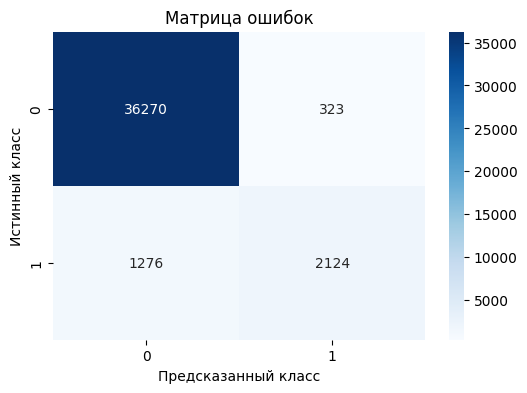

In [78]:
# Визуализируйте матрицу ошибок для удобства в интерпретации

plt.figure(figsize=(6, 4))
ax = sns.heatmap(pipe_confusion_matrix, annot=True, cmap='Blues', fmt='g')
ax.set_title('Матрица ошибок')
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
plt.show()

In [79]:
# Модель lr_pipe спрогнозировала у пациента из тестовой выборки наличие диабета. Вероятность ошибки этого прогноза больше 10%

# вероятности классов для всей тестовой выборки
y_test_proba_lr_pipe = lr_pipe.predict_proba(X_pipe_test)[:, 1]

# найдём все наблюдения, где модель предсказала класс 1
pred_pos_mask = y_test_pred_lr_pipe == 1

# FDR = FP / (FP + TP)  — доля ложных среди положительных прогнозов
fp = ((y_pipe_test == 0) & pred_pos_mask).sum()
tp = ((y_pipe_test == 1) & pred_pos_mask).sum()
fdr = fp / (fp + tp) if (fp + tp) else 0

fdr > 0.10   # больше 10 % ?

True

In [80]:
# Врачи диагностировали у пациента из тестовой выборки диабет. Модель lr_pipe сможет сделать правильный прогноз для данного пациента с вероятностью, большей 80%

# выбираем наблюдения, у которых истинный класс 1
true_pos_mask = y_pipe_test == 1

# чувствительность (TPR) = TP / (TP + FN)
tp = ((y_test_pred_lr_pipe == 1) & true_pos_mask).sum()
fn = ((y_test_pred_lr_pipe == 0) & true_pos_mask).sum()
tpr = tp / (tp + fn) if (tp + fn) else 0

tpr > 0.80   # больше 80 % ?


False

In [81]:
# Модель lr_pipe предоставила неверный прогноз для пациентов (в тестовой выборке), которые в реальности не имеют диагностированный диабет, больше, чем в 2% случаев

# FPR = FP / (FP + TN)  — доля ложных среди истинно не-больных
true_neg_mask = y_pipe_test == 0
fp = ((y_test_pred_lr_pipe == 1) & true_neg_mask).sum()
tn = ((y_test_pred_lr_pipe == 0) & true_neg_mask).sum()
fpr = fp / (fp + tn) if (fp + tn) else 0

fpr > 0.02   # больше 2 % ?

False

In [82]:
# Те пациенты (в тестовой выборке), у кого было предсказано отсутствие диабета (с помощью lr_pipe), в действительности имеют диабет менее, чем в 4% случаев.

# FDR для отрицательного класса = False Omission Rate (FOR)
# FOR = FN / (FN + TN)  — доля больных среди предсказанных «здоровыми»
pred_neg_mask = y_test_pred_lr_pipe == 0
fn = ((y_pipe_test == 1) & pred_neg_mask).sum()
tn = ((y_pipe_test == 0) & pred_neg_mask).sum()
for_rate = fn / (fn + tn) if (fn + tn) else 0

for_rate < 0.04   # меньше 4 % ?

True

In [83]:
# Постройте отчет по метрикам классификации

print(classification_report(y_pipe_test, y_test_pred_lr_pipe, digits=3))

              precision    recall  f1-score   support

           0      0.966     0.991     0.978     36593
           1      0.868     0.625     0.727      3400

    accuracy                          0.960     39993
   macro avg      0.917     0.808     0.852     39993
weighted avg      0.958     0.960     0.957     39993



# Задание 7
Постройте матрицу ошибок и выберите все верные утверждения из списка.

+++ Модель lr_pipe спрогнозировала у пациента из тестовой выборки наличие диабета. Вероятность ошибки этого прогноза больше 10%.  
Врачи диагностировали у пациента из тестовой выборки диабет. Модель lr_pipe сможет сделать правильный прогноз для данного пациента с вероятностью, большей 80%.  
Модель lr_pipe предоставила неверный прогноз для пациентов (в тестовой выборке), которые в реальности не имеют диагностированный диабет, больше, чем в 2% случаев.  
+++ Те пациенты (в тестовой выборке), у кого было предсказано отсутствие диабета (с помощью lr_pipe), в действительности имеют диабет менее, чем в 4% случаев.  


**Представьте, что для больницы критически важно не пропустить пациентов с диабетом, даже если это приведет к тому, что некоторым здоровым пациентам будет ошибочно поставлен предварительный диагноз. Какую метрику для целевого класса необходимо максимизировать для этой задачи, и чему равно ее значение в отчете по метрикам классификации для модели lr_pipe на тестовой выборке? Выберите из списка соответствующую метрику и её значение из отчета по метрикам классификации.**

precision, 0.97
precision, 0.87
recall, 0.99
**recall, 0.62**
f1-score, 0.98
f1-score, 0.73
f1-score, 0.96
accuracy, 0.96

### **Задание 8**

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обученную модель `lr_pipe` из задания 6.

* Тестовую выборку из задания 6: `X_pipe_test`, `y_pipe_test`.

Постройте ROC-кривую для модели `lr_pipe` на тестовой выборке и рассчитайте метрику AUC (AUC-ROC).

Для трех порогов классификации (0.25, 0.5, 0.75) для модели `lr_pipe` на тестовой выборке рассчитайте и сравните значения метрик: precision, recall, accuracy, f1.

На отрезке [0, 1] найдите такое значение порога классификации, при котором метрика f1 будет принимать максимальное значение на тестовой выборке (шаг поиска `step` — 0.001).

In [84]:
# Выполните прогноз вероятностей целевого класса на тестовой выборке моделью lr_pipe

y_test_proba_lr_pipe = lr_pipe.predict_proba(X_pipe_test)[:, 1]

In [85]:
# Постройте ROC-кривую для модели lr_pipe на тестовой выборке и рассчитайте метрику AUC

fpr_lr_pipe, tpr_lr_pipe, _ = roc_curve(y_pipe_test, y_test_proba_lr_pipe)
auc_lr_pipe = roc_auc_score(y_pipe_test, y_test_proba_lr_pipe)

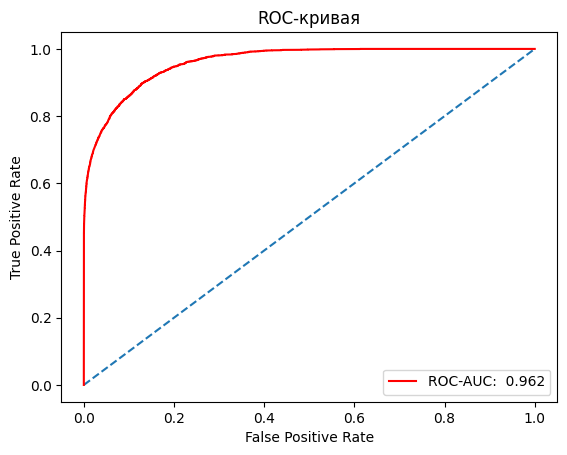

In [86]:
# Визуализируйте ROC-кривую и значение AUC на графике

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_lr_pipe, tpr_lr_pipe, c='r', label=f'ROC-AUC: {auc_lr_pipe: .3f}')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [87]:
# Для трех порогов классификации для модели lr_pipe на тестовой выборке 
# рассчитайте и сравните значения метрик: precision, recall, accuracy, f1

thresholds = [0.25, 0.5, 0.75]

def metrics_at_threshold(y_true, y_score, thresh):
    y_pred = (y_score >= thresh).astype(int)
    return {
        'threshold': thresh,
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred),
        'accuracy':  accuracy_score(y_true, y_pred),
        'f1':        f1_score(y_true, y_pred, zero_division=0)
    }

metrics_df = pd.DataFrame([
    metrics_at_threshold(y_pipe_test, y_test_proba_lr_pipe, t)
    for t in thresholds
])
metrics_df

,threshold,precision,recall,accuracy,f1
0,0.25,0.655573,0.747353,0.945140,0.698461
1,0.50,0.868002,0.624706,0.960018,0.726526
2,0.75,0.977077,0.501471,0.956617,0.662779


In [88]:
# На отрезке [0, 1] найдите такое значение порога классификации, при котором метрика f1 будет принимать максимальное значение на тестовой выборке
# Шаг поиска — 0.001

step = 0.001

thresholds = np.arange(0, 1 + step, step)
f1_scores = [f1_score(y_pipe_test, (y_test_proba_lr_pipe >= t).astype(int)) for t in thresholds]

best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

best_thresh, best_f1

(0.454, 0.7309036445332002)

In [89]:
auc_lr_pipe

0.9618800405413442

## Задание 8 !!!
Рассчитайте метрику AUC для модели lr_pipe на тестовой выборке. 

Для трех порогов классификации (0.25, 0.5, 0.75) для модели lr_pipe на тестовой выборке рассчитайте и сравните значения метрик: precision, recall, accuracy, f1.

Выберите все верные утверждения из списка.

Среди трех порогов классификации наилучшее значение f1 принимает при пороге 0.25.  
++++ Precision монотонно растет с увеличением порога классификации.  
f1 монотонно растёт с увеличением порога классификации.  
++++ Метрика AUC не меняется с изменением порога.  
Чтобы улучшить recall, жертвуя precision, необходимо увеличить порог классификации.  

**0.454**

### **Коэффициент Джини**

**Коэффициент Джини (Gini)** — это метрика оценки качества моделей бинарной классификации, которая представляет собой линейное преобразование метрики AUC (Area Under the ROC Curve):

$$\text{Gini}=2 \times \text{AUC}−1$$

Значение Gini изменяется от 0 (отсутствие разделяющей способности) до 1 (идеальная модель), что позволяет интерпретировать Gini как меру корреляции между предсказанными вероятностями и истинными метками класса.

### ***Задание 9***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обученную модель `lr_pipe` из задания 6.

* Тестовую выборку из задания 6: `X_pipe_test`, `y_pipe_test`.

Реализуем две простые функции (модели) для предсказания вероятностей целевого класса в тестовой выборке:

* `random_uniform` — функция (модель), предсказывающая вероятности случайно из равномерного распределения.

* `linear_hba1c` — функция (модель), предсказывающая вероятности с помощью линейного преобразования (стандартизации) значений фактора HbA1c_level.

На тестовой выборке сравните точность прогноза модели `lr_pipe` и функций (моделей) `random_uniform` и `linear_hba1c`, построив ROC-кривую и рассчитав значения метрики AUC и коэффициента Gini.

In [90]:
# Предскажите вероятности целевого класса в тестовой выборке с помощью random_uniform
# Не забудьте зафиксировать RANDOM_STATE

def random_uniform(N, random_state=None):
    """
    Возвращает случайный прогноз вероятностей целевого класса из равномерного распределения.

    Аргументы:
        N (int): Длина вектора прогноза вероятностей целевого класса.
        random_state (int): Параметр, фиксирующий случайное состояние результата выполнения функции. По умолчанию не используется (None).

    Возвращает:
        numpy.ndarray: Предсказанные вероятности целевого класса.
    """
    rng = np.random.RandomState(random_state)
    return rng.uniform(0, 1, N)

y_test_proba_random_uniform = random_uniform(len(y_pipe_test), random_state=RANDOM_STATE)

In [91]:
# Предскажите вероятности целевого класса в тестовой выборке с помощью linear_hba1c

def linear_hba1c(hba1c_level):
    """
    Возвращает прогноз вероятностей целевого класса с помощью линейного преобразования (стандартизации) значений фактора HbA1c_level.

    Аргументы:
        hba1c_level (numpy.ndarray): Вектор значений фактора HbA1c_level в тестовой выборке.
        
    Возвращает:
        numpy.ndarray: Предсказанные вероятности целевого класса.
    """
    return (hba1c_level - hba1c_level.min()) / (hba1c_level.max() - hba1c_level.min())
hba1c_test = X_pipe_test['HbA1c_level'].values
y_test_proba_linear_hba1c = linear_hba1c(hba1c_test)

In [92]:
# Дополните функцию gini

def gini(y_true, y_score):
    """
    Возвращает значение коэффициента Gini для предсказанных вероятностей.

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_score (numpy.ndarray): Предсказанные вероятности целевого класса.

    Возвращает:
        float: Значение коэффициента Gini для предсказанных вероятностей.
    """
    auc = roc_auc_score(y_true, y_score)
    return 2 * auc - 1

In [93]:
# Постройте ROC-кривые для random_uniform и linear_hba1c на тестовой выборке

fpr_random_uniform, tpr_random_uniform, _ = roc_curve(y_pipe_test, y_test_proba_random_uniform)
fpr_linear_hba1c, tpr_linear_hba1c, _ = roc_curve(y_pipe_test, y_test_proba_linear_hba1c)

In [94]:
# Рассчитайте метрику AUC для random_uniform и linear_hba1c на тестовой выборке

auc_random_uniform = roc_auc_score(y_pipe_test, y_test_proba_random_uniform)
auc_linear_hba1c = roc_auc_score(y_pipe_test, y_test_proba_linear_hba1c)

In [95]:
# Рассчитайте коэффициент Gini для lr_pipe, random_uniform и linear_hba1c на тестовой выборке

gini_lr_pipe = gini(y_pipe_test, y_test_proba_lr_pipe)
gini_random_uniform = gini(y_pipe_test, y_test_proba_random_uniform)
gini_linear_hba1c = gini(y_pipe_test, y_test_proba_linear_hba1c)

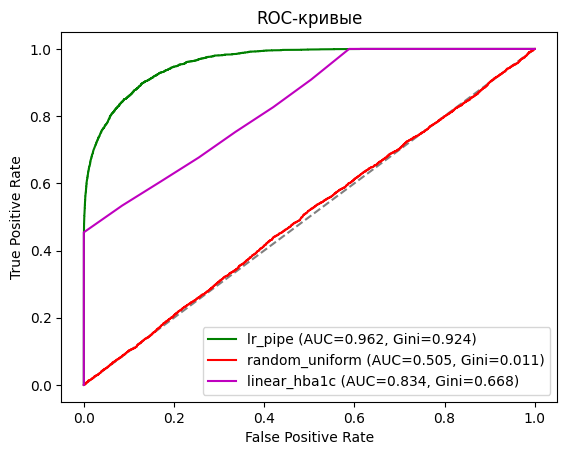

In [96]:
# Визуализируйте ROC-кривые и сравните значения AUC и Gini для трех моделей

plt.plot([0, 1], [0, 1], linestyle='--', c='gray')
plt.plot(fpr_lr_pipe, tpr_lr_pipe, c='g', label=f'lr_pipe (AUC={auc_lr_pipe:.3f}, Gini={gini_lr_pipe:.3f})')
plt.plot(fpr_random_uniform, tpr_random_uniform, c='r', label=f'random_uniform (AUC={auc_random_uniform:.3f}, Gini={gini_random_uniform:.3f})')
plt.plot(fpr_linear_hba1c, tpr_linear_hba1c, c='m', label=f'linear_hba1c (AUC={auc_linear_hba1c:.3f}, Gini={gini_linear_hba1c:.3f})')
plt.title('ROC-кривые')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [97]:
summary = pd.DataFrame({
    'Model': ['lr_pipe', 'random_uniform', 'linear_hba1c'],
    'AUC': [auc_lr_pipe, auc_random_uniform, auc_linear_hba1c],
    'Gini': [gini_lr_pipe, gini_random_uniform, gini_linear_hba1c]
})

summary

,Model,AUC,Gini
0,lr_pipe,0.961880,0.923760
1,random_uniform,0.505485,0.010970
2,linear_hba1c,0.834121,0.668242


 ответ 2,3,5 неверно?
# ответ 2,3, 6 верно!

Задание 9
На тестовой выборке сравните точность прогноза модели lr_pipe и функций (моделей) random_uniform и linear_hba1c, построив ROC-кривую и рассчитав значения метрики AUC и коэффициента Gini.

Выберите все верные утверждения из списка.

Все три модели показали высокую предсказательную способность, так как их AUC превышает 0.5, а Gini больше 0.  
Модель random_uniform служит точкой отсчета, демонстрируя качество случайного угадывания.  
Модель linear_hba1c, основанная лишь на одном признаке HbA1c, показывает значительно лучшее качество, чем случайная: разница коэффициентов Gini превышает 0.6.  
Ни одна из моделей не достигла значения Gini, равного 0.9.  
Модель linear_hba1c показывает заметно худшую точность по сравнению с моделью lr_pipe: Gini модели lr_pipe больше Gini модели linear_hba1c более, чем на 0.3.  
Модель linear_hba1c показывает хорошую точность, поскольку ее Gini больше 0.5.  